# UP 229 Final Project
# Jennifer Badger and Bryan Graveline

For our final project, we assessed the effect of historic redlining patterns on current-day PM 2.5 levels in Los Angeles. 
To do so, we used neighborhood HOLC grades from [Mapping Inequality](https://dsl.richmond.edu/panorama/redlining/#loc=5/39.1/-94.58)
and air quality data from [PurpleAir](https://www2.purpleair.com/).

This notebook contains a comprehensive description of the analysis we performed.

## Purple Air CSV

The first step of our analysis was to extract air quality data for Los Angeles from the PurpleAir website. 

In [1]:
import os
import glob
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.tri as tri
from scipy.interpolate import griddata
import geopandas as gpd

##### Working Directory

In [2]:
#from https://www.tutorialspoint.com/python/os_chdir.htm
#first retrieving working directory
#retval = os.getcwd()
#print ("Current working directory %s" % retval)
#returned: Current working directory /Users/jenniferbadger/Documents/GitHub/229project

#now changing working directory to where CSVs are located
#os.chdir("/Users/jenniferbadger/Documents/GitHub/229project/PAprimary")
#retval = os.getcwd()
#print ("Current working directory %s" % retval)
#returned: Current working directory /Users/jenniferbadger/Documents/GitHub/229project/PAprimary

##### CSV Wrangling

These CSVs were exported from Purple Air's data download tool and contain PM 2.5 24 hour average data for 2019. 

The sensors were chosen using the Purple Air interactive map to subset first on a portion of greater LA that would include most of the HOLC boundaries and on sensors with names A-C that began delivering data during or before 2019. The reason for subsetting is that I ran into issues with hardware memory, limited interaction capability with regard to which CSVs I could choose (I had to download primary and secondary datasets for each sensor although the secorndary datasets were useless) and considering historical data was unavailable via the API. Names are defined by users and are not associated with location so are spatially random. Importantly, this subset yielded California Clean Air Coalition and AQMD/NASA sensors which are well distributed; eg. Echo Park, Pacoima, Brentwood, Inglewood, Montebello, Arcadia, Pacific Palisades to name a few. 

This subset yielded observations for some or all of the days in 2019 for 116 different point locations throughout greater Los Angeles.

https://api.purpleair.com
https://www.purpleair.com/sensorlist

In [3]:
#from https://sempioneer.com/python-for-seo/how-to-combine-multiple-csv-files-in-python/
#file_extension = '.csv'
#all_filenames = [i for i in glob.glob(f"*{file_extension}")]

#checking correct files are retieved
#print(f"These are all of the filenames ending in .csv {all_filenames}.")

In [4]:
# prelim to concatenating two to see if we lose row 0 which contains location information
#all_filenames[0]

#cheking encoding of PA CSVs
#with open('Brentwood School West Campus (outside) (34.061087 -118.47584) Primary 1440_minute_average 01_01_2019 12_31_2019.csv') as q:
    #print(q)

#adapting code with encoding='UTF-8'    
#df = pd.read_csv('Brentwood School West Campus (outside) (34.061087 -118.47584) Primary 1440_minute_average 01_01_2019 12_31_2019.csv', 
                 #delimiter=',', encoding='UTF-8')

#print(df.shape) # shape is correct! but missing important location info

In [5]:
#testing concatenating three csvs
#combined_csv_data = pd.concat([pd.read_csv(f, delimiter=',', encoding='UTF-8') for f in all_filenames])

#combined_csv_data.head(-50) #concatenates 

In [7]:
import re

#I think the issue is the path.I PAprimary is on github so I tried changing the path to 
#our repo where the folder is but that isn't working yet......
#path = r'https://github.com/JBgeog-ucla/229project/tree/main/PAprimary' # use your path

#this one works for me of course b/c I have the folder locally
path = r'/Users/Katie/Documents/GitHub/229project/PAprimary' # use your path
all_files = glob.glob(path + "/*.csv")


li = [] #only need this if appending to list instead of df
#https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe

for filename in all_files:
    #reads csv into a dataframe
    df = pd.read_csv(filename, index_col=None,encoding='UTF-8', delimiter=',')
    #print(filename)
    filename = filename.split('/')
    filename = filename[-1]
    #print(filename)
    #adds csv extention- may be unnecessary
    #file_extension = '.csv'
    #converts file name to a i string list
    #filename = glob.glob(f"*{file_extension}")
    #adds file name to column
    df['filename'] = filename
    #print(df['filename'])
    #creates a list of parsed out strings inside parenthesis
    parenth = re.findall('\(([^)]+)', filename)
    #creates a 2 string list of lat, long
    lat_long = parenth[-1].split(" ")
    #extracts lat/long from list assignes them to column
    #and coverts them to float
    df['lat'] = lat_long[0] #astype(float)
    df['lat'] = df['lat'].astype(float)
    df['long'] = lat_long[-1] 
    df['long'] = df['long'].astype(float)
    #replaces NaN with zeroes
    df['PM2.5_ATM_ug/m3']= df['PM2.5_ATM_ug/m3'].fillna(0)
    df['PM2.5_CF1_ug/m3'] = df['PM2.5_CF1_ug/m3'].fillna(0)
    #filters for rows where Pm 2.5 values don't equal zero
    df = df[(df['PM2.5_ATM_ug/m3'] != 0)]
    #df = df[(df['PM2.5_CF1_ug/m3'] != 0)]
    #takes mean pm2.5
    df['PM2.5 ATM Mean'] = df['PM2.5_ATM_ug/m3'].mean()
    df['PM2.5 CF1 Mean'] = df['PM2.5_CF1_ug/m3'].mean()
    #df['PM2.5 ATM Mean'] = df[(df['PM2.5_ATM_ug/m3'] != 0)].mean()
    #df['PM2.5 CF1 Mean'] = df[(df['PM2.5_CF1_ug/m3']!= 0)].mean()
    
    #PM25_ATM_Mean = df[(df['PM2.5_ATM_ug/m3'] != 0)].mean()
    #PM25_CFI_Mean = df[(df['PM2.5_CF1_ug/m3']!= 0)].mean()
    #appends to df
    #df= df.append(df)
    #alt way to append to list
    
    #I only need the values from row 0, columns 11-14 to concat into one csv
    #drops unneeded columns
    try:
        df.drop(['PM1.0_CF1_ug/m3', 'PM2.5_CF1_ug/m3', 'PM10.0_CF1_ug/m3', 'UptimeMinutes', 
             'RSSI_dbm', 'Temperature_F', 'Humidity_%', 'PM2.5_ATM_ug/m3', 'Unnamed: 9'],
            inplace=True, axis = 1) 
    except:
        df.drop(['PM1.0_CF1_ug/m3', 'PM2.5_CF1_ug/m3', 'PM10.0_CF1_ug/m3', 'UptimeMinutes', 
             'RSSI_dbm', 'Temperature_F', 'Humidity_%', 'PM2.5_ATM_ug/m3'],
            inplace=True, axis = 1) 
        continue
    df = df.reset_index(drop=True)
    #print(df)
    try:
        newdf = df.iloc[0]
    except:
        newdf = df.iloc[-1]
        continue
    #converting series to df and flipping on its end
    newdf = pd.DataFrame(newdf).transpose()
    #newdf['PM2.5 ATM Mean'] = PM25_ATM_Mean
    #newdf['PM2.5 CF1 Mean'] = PM25_CFI_Mean
    li.append(newdf)
    #bigdf= bigdf.append(newdf)
    #alt way to convert series to df
    #newdf = newdf.to_frame()

final_frame = pd.concat(li, axis=0, ignore_index=True) 
final_frame.head(-10)


#newdf.head(70)
#final_frame = pd.concat([newdf], axis=0, ignore_index=True) 


#some code for spllitting on parenthesis
#s = 'Name(something)'
#re.search('\(([^)]+)', s).group(1)
#'something'

#https://stackoverflow.com/questions/45947887/python-looping-through-csv-files-and-their-columns
#for i in numFiles:
    #file = open(os.path.join(pathName, i), "rU")
    #reader = csv.reader(file, delimiter=',')
    #for row in reader:
        #for column in row:
            #print(column)
            #if column=="SPECIFIC VALUE":
                #do stuf                

IndexError: list index out of range

In [8]:
#all_files[1]

In [9]:
final_frame.to_csv(r'/Users/jenniferbadger/Documents/GitHub/229project/PAprimary/final_frame.csv')

NameError: name 'final_frame' is not defined

## HOLC and Sensor Join Analysis

Now that we had created a sensors dataset, our next step was to import the redlining dataset from Mapping Inequality.

In [10]:
# First we bring in the HOLC data (fname) and the air quality dataset (fname2). We downloaded the former from Mapping
# Inequality and created the latter in the code above.

fname = "C:/Users/Katie/Documents/GitHub/229project/CALosAngeles1939.geojson"
fname2 = "C:/Users/Katie/Documents/GitHub/229project/final_frame.csv"

In [11]:
# We created a dataframe for each file.

holc = gpd.read_file(fname)
sensors = gpd.read_file(fname2)

In [12]:
# Next, we take a look at each dataframe.

holc.head()
sensors.head()

field_1               created_at  \
0       0  2019-03-16 00:00:00 UTC   
1       1  2019-03-16 00:00:00 UTC   
2       2  2019-03-26 00:00:00 UTC   
3       3  2019-03-27 00:00:00 UTC   
4       4  2019-01-09 00:00:00 UTC   

                                            filename        lat         long  \
0  CCA 61st and King (outside) (33.98329 -118.183...   33.98329  -118.183926   
1  CCA 52nd Dr and Heliotrope (outside) (33.98995...   33.98995  -118.178093   
2  Adams Square (inside) (inside) (34.133594 -118...  34.133594  -118.241213   
3  CSUN Live Oak (outside) (34.238179 -118.528333...  34.238179  -118.528333   
4  6th St (inside) (34.020076 -118.49534) Primary...  34.020076   -118.49534   

       PM2.5 ATM Mean      PM2.5 CF1 Mean geometry  
0  16.995496183206104   18.17295801526718     None  
1   16.32888246628132  17.597437379576103     None  
2  12.812236842105255  14.105855263157892     None  
3  13.484825581395349  13.641279069767442     None  
4   6.793395348837209   7.069488372093021     None

In [13]:
# Then we convert the sensors dataframe to a geodataframe using the points_from_xy function from class.

sensors = gpd.GeoDataFrame(
    sensors, geometry=gpd.points_from_xy(sensors.long, sensors.lat, crs='EPSG:4326'))

[Text(0.5, 1.0, 'HOLC Neighborhood Grades and Air Quality Station Locations')]

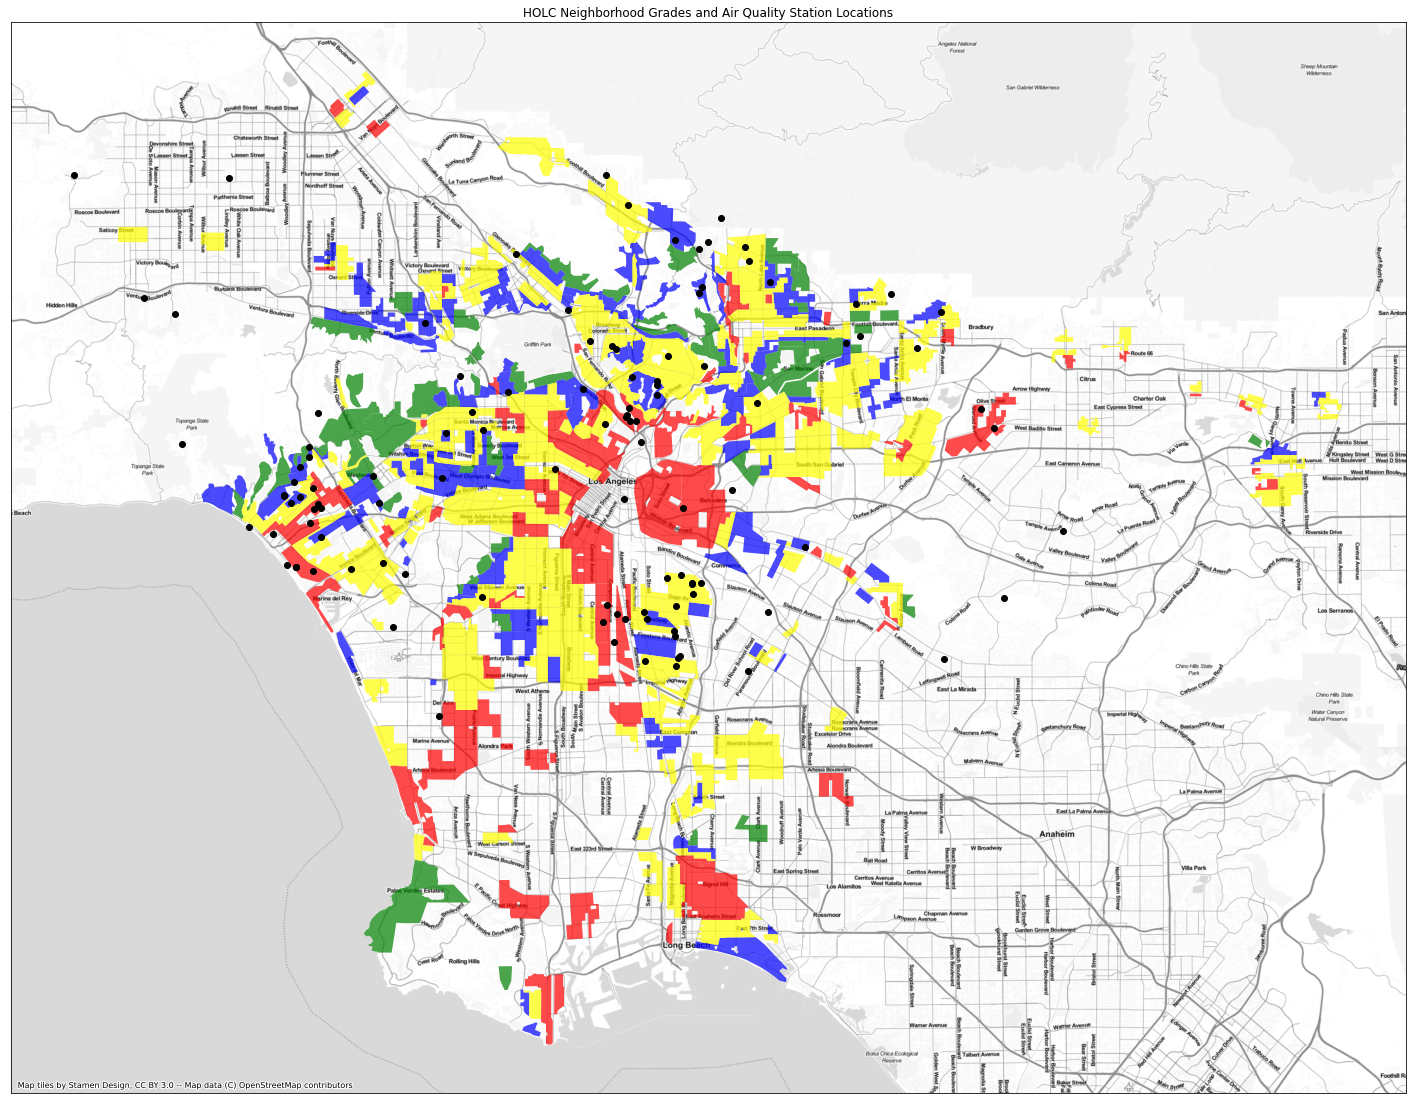

In [14]:
# Now we are able to map the HOLC neighborhood grades and the locations of the air quality stations.

fig, ax = plt.subplots(1,1, figsize=(25,25))
color_mapping = {"A": "green", "B": "blue", "C":"yellow","D":"red"}
holc.to_crs('EPSG:3857').plot(color=holc["holc_grade"].map(color_mapping),legend = True, ax=ax, alpha= 0.7)
sensors.to_crs('EPSG:3857').plot(ax=ax, color='black',legend=True)

ctx.add_basemap(ax, zoom = 12, source = ctx.providers.Stamen.TonerLite)

ax.set_xticks([])
ax.set_yticks([])

ax.set(title='HOLC Neighborhood Grades and Air Quality Station Locations') 

In [15]:
# Now that we've mapped the data, we can join the two datasets and analyze the average air quality score for each
# neighborhood grade.

In [16]:
# Here we conduct a left join: we keep all the sensors but discard neighborhoods with no sensors in them.

joindf = gpd.sjoin(sensors.to_crs('EPSG:4326'), holc.to_crs('EPSG:4326'), how="left", op='intersects')

In [17]:
# The sensors that don't overlay a neighborhood have an NaN value in the holc_grade column, which is difficult to 
#analyze. We change it to a string "NA", similar to our strings of "A", "B", "C", and "D".

joindf.holc_grade = joindf.holc_grade.fillna(value="NA")
joindf.head()

field_1               created_at  \
0       0  2019-03-16 00:00:00 UTC   
1       1  2019-03-16 00:00:00 UTC   
2       2  2019-03-26 00:00:00 UTC   
3       3  2019-03-27 00:00:00 UTC   
4       4  2019-01-09 00:00:00 UTC   

                                            filename        lat         long  \
0  CCA 61st and King (outside) (33.98329 -118.183...   33.98329  -118.183926   
1  CCA 52nd Dr and Heliotrope (outside) (33.98995...   33.98995  -118.178093   
2  Adams Square (inside) (inside) (34.133594 -118...  34.133594  -118.241213   
3  CSUN Live Oak (outside) (34.238179 -118.528333...  34.238179  -118.528333   
4  6th St (inside) (34.020076 -118.49534) Primary...  34.020076   -118.49534   

       PM2.5 ATM Mean      PM2.5 CF1 Mean                     geometry  \
0  16.995496183206104   18.17295801526718  POINT (-118.18393 33.98329)   
1   16.32888246628132  17.597437379576103  POINT (-118.17809 33.98995)   
2  12.812236842105255  14.105855263157892  POINT (-118.24121 34.13359)   
3  13.484825581395349  13.641279069767442  POINT (-118.52833 34.23818)   
4   6.793395348837209   7.069488372093021  POINT (-118.49534 34.02008)   

   index_right  name holc_id holc_grade  \
0        226.0  None    C142          C   
1        226.0  None    C142          C   
2        256.0  None     C19          C   
3          NaN   NaN     NaN         NA   
4          NaN   NaN     NaN         NA   

                               area_description_data  
0  {'0': 'Los Angeles County', '2': '90 N/A', '3'...  
1  {'0': 'Los Angeles County', '2': '90 N/A', '3'...  
2  {'0': 'Los Angeles County', '2': '80 20', '3':...  
3                                                NaN  
4                                                NaN

In [18]:
# Here we doublecheck our join: we have 110 sensors and 416 neighborhoods. As expected, our join has 110 rows.

#len(sensors.index)
#len(holc.index)
len(joindf.index)

110

<AxesSubplot:title={'center':'PM2.5 CF1 Mean'}, xlabel='holc_grade'>

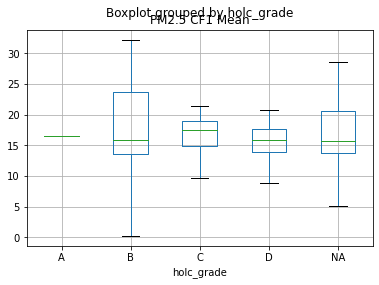

In [19]:
# Time to plot the results! First, we convert the PM 2.5 column to a float, then we plot.

joindf['PM2.5 CF1 Mean'] = joindf['PM2.5 CF1 Mean'].astype('float')
joindf.boxplot('PM2.5 CF1 Mean', by = 'holc_grade', showfliers = False)

In [20]:
# It looks like HOLC grade doesn't have a big effect on PM 2.5. But what do our sample sizes look like?

joindf.groupby('holc_grade').count()

field_1  created_at  filename  lat  long  PM2.5 ATM Mean  \
holc_grade                                                             
A                 1           1         1    1     1               1   
B                25          25        25   25    25              25   
C                30          30        30   30    30              30   
D                15          15        15   15    15              15   
NA               39          39        39   39    39              39   

            PM2.5 CF1 Mean  geometry  index_right  name  holc_id  \
holc_grade                                                         
A                        1         1            1     0        1   
B                       25        25           25     0       25   
C                       30        30           30     0       30   
D                       15        15           15     0       15   
NA                      39        39            0     0        0   

            area_description_data  
holc_grade                         
A                               1  
B                              25  
C                              30  
D                              15  
NA                              0

In [21]:
# A sample size of only 1 for grade A neighborhoods! And 39 of our sensors are going to waste. This is a problem...

## Interpolated Surface

The Purple Air CSV, extracted above, gave us over 100 datapoints spread across the Los Angeles region. However, as we noted at the end of the last section, 39 of those sensors don't overlay an HOLC neighborhood. And only 1 sensor overlays a grade A neighborhood. We're not getting great bang for our data buck. So, we decided to create an interpolated surface that approximates the PM 2.5 levels throughout the study area using nearby sensors.

In [22]:
#purple_df = pd.read_csv('/Users/jenniferbadger/Documents/GitHub/229project/final_frame.csv', index_col=None,encoding='UTF-8', delimiter=',')
purple_df = pd.read_csv('/Users/katie/Documents/GitHub/229project/final_frame.csv', index_col=None,encoding='UTF-8', delimiter=',')

#purple_df.drop(['Unnamed: 0'])
purple_df['PM2.5 CF1 Mean'].mean() #94.5
purple_df['PM2.5 CF1 Mean'].max() #4475! 
purple_df['PM2.5 CF1 Mean'].min() #0.064
purple_df['PM2.5 CF1 Mean'].median() #15.9

#Trimming data for outliers or potentially uncalibrated sensors
purple_trim = purple_df[purple_df['PM2.5 CF1 Mean']< 30]
purple_trim = purple_trim[purple_df['PM2.5 CF1 Mean']> 5]
purple_trim.head()
#purple_df.head()

<ipython-input-22-571a612eb405>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  purple_trim = purple_trim[purple_df['PM2.5 CF1 Mean']> 5]


Unnamed: 0               created_at  \
0           0  2019-03-16 00:00:00 UTC   
1           1  2019-03-16 00:00:00 UTC   
2           2  2019-03-26 00:00:00 UTC   
3           3  2019-03-27 00:00:00 UTC   
4           4  2019-01-09 00:00:00 UTC   

                                            filename        lat        long  \
0  CCA 61st and King (outside) (33.98329 -118.183...  33.983290 -118.183926   
1  CCA 52nd Dr and Heliotrope (outside) (33.98995...  33.989950 -118.178093   
2  Adams Square (inside) (inside) (34.133594 -118...  34.133594 -118.241213   
3  CSUN Live Oak (outside) (34.238179 -118.528333...  34.238179 -118.528333   
4  6th St (inside) (34.020076 -118.49534) Primary...  34.020076 -118.495340   

   PM2.5 ATM Mean  PM2.5 CF1 Mean  
0       16.995496       18.172958  
1       16.328882       17.597437  
2       12.812237       14.105855  
3       13.484826       13.641279  
4        6.793395        7.069488

In [23]:
len(purple_df)

110

In [24]:
len(purple_trim)

97

[(-118.7, -117.9), (33.9, 34.25)]

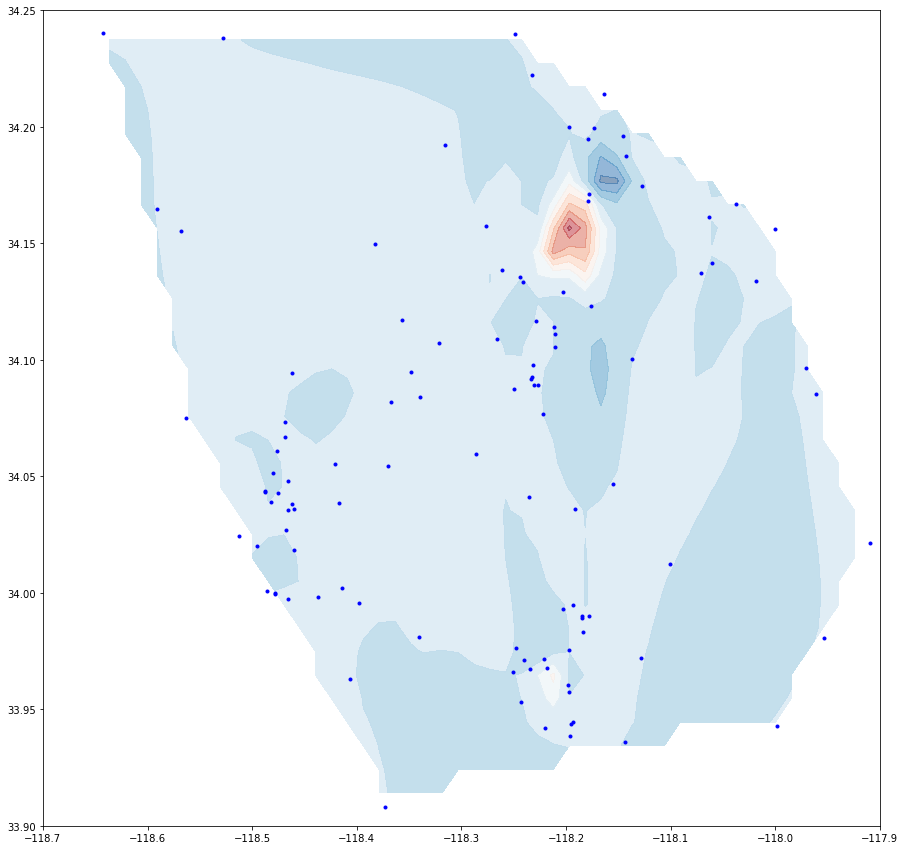

In [25]:
#CONTOUR SURFACE: FIRST ITERATION 

#https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html

xpts = purple_df['long']
ypts = purple_df['lat']
zpts = purple_df['PM2.5 CF1 Mean']

min(xpts) #-118.642964
max(xpts) #-117.90991

min(ypts) #33.907907
max(ypts) #34.240106

#creating the plot
fig, ax = plt.subplots(figsize=(15,15))

#linspace returns evenly spaced numbers over a specified interval
#https://numpy.org/devdocs/reference/generated/numpy.linspace.html
xi = np.linspace(start = -119.0, stop = -117.5, num = 100)
yi = np.linspace(33.5, 34.5, 100)


#xi2 = np.linspace(purple_df['long'].min(), purple_df['long'].max())
#yi2 = np.linspace(purple_df['lat'].min(), purple_df['lat'])

X, Y = np.meshgrid(xi,yi)

#interpolation
#griddata interpolates a surface at the points specified by (xi,yi) to produce zi
#scipy.interpolate.griddata(points, values, xi, method='linear', fill_value=nan, rescale=False)
zi = griddata((xpts, ypts), zpts, (X,Y), method='cubic')

#draws contour lines
ax.contour(zi, levels=10, linewidths=0.15, colors='k')

#fills contours, cmap = colormap, alpha = transparency
contour = ax.contourf(xi, yi, zi, levels=10, cmap = "RdBu_r",  alpha = 0.5)

#plots lat/long using bo= blue circle markers
ax.plot(xpts, ypts, 'bo', markersize = 3)
ax.set(xlim=(-118.7, -117.9), ylim=(33.9, 34.25))

In [26]:
#Defining x and y pts in terms of projection 4326
purple_trim_gdf = gpd.GeoDataFrame(
    purple_trim, geometry = gpd.points_from_xy(purple_trim.long, purple_trim.lat, crs='EPSG:4326'))
purple_trim_gdf.head()

Unnamed: 0               created_at  \
0           0  2019-03-16 00:00:00 UTC   
1           1  2019-03-16 00:00:00 UTC   
2           2  2019-03-26 00:00:00 UTC   
3           3  2019-03-27 00:00:00 UTC   
4           4  2019-01-09 00:00:00 UTC   

                                            filename        lat        long  \
0  CCA 61st and King (outside) (33.98329 -118.183...  33.983290 -118.183926   
1  CCA 52nd Dr and Heliotrope (outside) (33.98995...  33.989950 -118.178093   
2  Adams Square (inside) (inside) (34.133594 -118...  34.133594 -118.241213   
3  CSUN Live Oak (outside) (34.238179 -118.528333...  34.238179 -118.528333   
4  6th St (inside) (34.020076 -118.49534) Primary...  34.020076 -118.495340   

   PM2.5 ATM Mean  PM2.5 CF1 Mean                     geometry  
0       16.995496       18.172958  POINT (-118.18393 33.98329)  
1       16.328882       17.597437  POINT (-118.17809 33.98995)  
2       12.812237       14.105855  POINT (-118.24121 34.13359)  
3       13.484826       13.641279  POINT (-118.52833 34.23818)  
4        6.793395        7.069488  POINT (-118.49534 34.02008)

In [27]:
#converting gdf with projected coordinates back into df
purple_trim_proj= purple_trim_gdf

#converting geometry column into individual lat/long
purple_trim_proj['lat proj'] = purple_trim_gdf.geometry.apply(lambda x: x.y)

purple_trim_proj['long proj'] = purple_trim_gdf.geometry.apply(lambda x: x.x)

#dropping column
purple_trim_proj = purple_trim_proj.drop(['latproj'], axis = 1)

purple_trim_proj.head()

KeyError: "['latproj'] not found in axis"

[(-118.7, -117.9), (33.9, 34.25)]

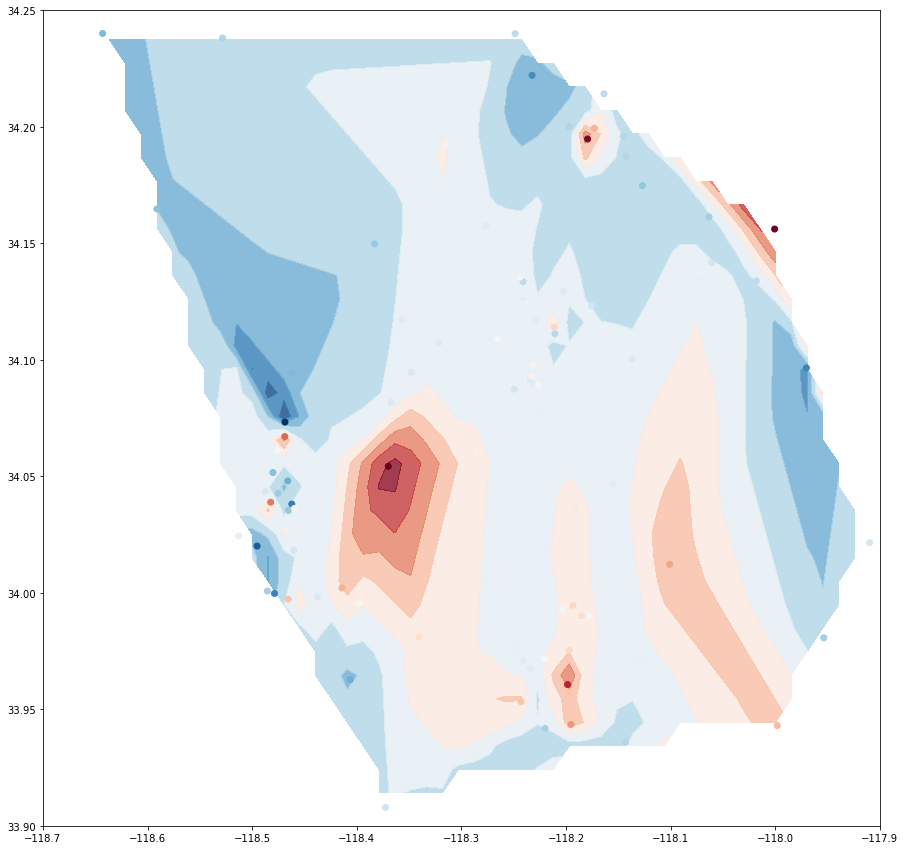

In [28]:
#CONTOUR SURFACE: FINAL ITERATION 

xpts = purple_trim_proj['long proj']
ypts = purple_trim_proj['lat proj']
zpts = purple_trim_proj['PM2.5 CF1 Mean']

min(xpts) #-118.642964
max(xpts) #-117.90991

min(ypts) #33.907907
max(ypts) #34.240106

#creating the plot
fig, ax = plt.subplots(figsize=(15,15))

#linspace returns evenly spaced numbers over a specified interval
#https://numpy.org/devdocs/reference/generated/numpy.linspace.html
xi = np.linspace(start = -119.0, stop = -117.5, num = 100)
yi = np.linspace(33.5, 34.5, 100)

# meshgrid creates a rectangular grid out of an array of x values and an array of y values.
X, Y = np.meshgrid(xi,yi)

#interpolation
#griddata interpolates a surface at the points specified by (xi,yi) to produce zi
#scipy.interpolate.griddata(points, values, xi, method='linear', fill_value=nan, rescale=False)
zi = griddata((xpts, ypts), zpts, (X,Y), method='linear')
                       
#draws contour lines
ax.contour(zi, levels=10, linewidths= 1.5, colors='k')

#fills contours, cmap = colormap, alpha = transparency
contour = ax.contourf(xi, yi, zi, levels=10, cmap = "RdBu_r",  alpha = 0.8)

#plots sensor locations using bo= blue circle markers
#ax.plot(xpts, ypts, 'bo', markersize = 3)

#plots sensor locations with colormap expressing pm2.5 mean gradients
scatter = ax.scatter(xpts, ypts, c = zpts ,cmap = "RdBu_r")
#setting the axes
ax.set(xlim=(-118.7, -117.9), ylim=(33.9, 34.25))


In [29]:
zpts

0      18.172958
1      17.597437
2      14.105855
3      13.641279
4       7.069488
         ...    
105    20.615290
106    19.214658
107    29.090000
108    17.884022
109    28.615000
Name: PM2.5 CF1 Mean, Length: 97, dtype: float64

In [30]:
#saving the fig
#fig.savefig('contour_scatter.png')

#fig.savefig('contour.png')

In [31]:
#checking interpolated value array
len(zi) #1128

100

In [32]:
print(zi) # zi looks like a bunch of nans

np.count_nonzero(np.isnan(zi)) #8872
np.isnan(zi).sum() #returns 8872

np.count_nonzero(~np.isnan(zi)) #1128 values

#zi total = 10000 values
#approximately 10% of the nodes have predicted pm 2.5 values

#has to do with points being outside of convex hull
#https://stackoverflow.com/questions/37643934/nan-values-are-from-griddata

zi_df = pd.DataFrame(zi)
zi_df.head()

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


0   1   2   3   4   5   6   7   8   9   ...  90  91  92  93  94  95  96  \
0 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
1 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
2 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
3 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
4 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   

   97  98  99  
0 NaN NaN NaN  
1 NaN NaN NaN  
2 NaN NaN NaN  
3 NaN NaN NaN  
4 NaN NaN NaN  

[5 rows x 100 columns]

In [33]:
#checking linspace array
len(xi) #100
xi #returns a reasonable looking array


array([-119.        , -118.98484848, -118.96969697, -118.95454545,
       -118.93939394, -118.92424242, -118.90909091, -118.89393939,
       -118.87878788, -118.86363636, -118.84848485, -118.83333333,
       -118.81818182, -118.8030303 , -118.78787879, -118.77272727,
       -118.75757576, -118.74242424, -118.72727273, -118.71212121,
       -118.6969697 , -118.68181818, -118.66666667, -118.65151515,
       -118.63636364, -118.62121212, -118.60606061, -118.59090909,
       -118.57575758, -118.56060606, -118.54545455, -118.53030303,
       -118.51515152, -118.5       , -118.48484848, -118.46969697,
       -118.45454545, -118.43939394, -118.42424242, -118.40909091,
       -118.39393939, -118.37878788, -118.36363636, -118.34848485,
       -118.33333333, -118.31818182, -118.3030303 , -118.28787879,
       -118.27272727, -118.25757576, -118.24242424, -118.22727273,
       -118.21212121, -118.1969697 , -118.18181818, -118.16666667,
       -118.15151515, -118.13636364, -118.12121212, -118.10606

In [34]:
#checking linspace array
len(yi) #100
yi #returns a reasonable looking array

array([33.5       , 33.51010101, 33.52020202, 33.53030303, 33.54040404,
       33.55050505, 33.56060606, 33.57070707, 33.58080808, 33.59090909,
       33.6010101 , 33.61111111, 33.62121212, 33.63131313, 33.64141414,
       33.65151515, 33.66161616, 33.67171717, 33.68181818, 33.69191919,
       33.7020202 , 33.71212121, 33.72222222, 33.73232323, 33.74242424,
       33.75252525, 33.76262626, 33.77272727, 33.78282828, 33.79292929,
       33.8030303 , 33.81313131, 33.82323232, 33.83333333, 33.84343434,
       33.85353535, 33.86363636, 33.87373737, 33.88383838, 33.89393939,
       33.9040404 , 33.91414141, 33.92424242, 33.93434343, 33.94444444,
       33.95454545, 33.96464646, 33.97474747, 33.98484848, 33.99494949,
       34.00505051, 34.01515152, 34.02525253, 34.03535354, 34.04545455,
       34.05555556, 34.06565657, 34.07575758, 34.08585859, 34.0959596 ,
       34.10606061, 34.11616162, 34.12626263, 34.13636364, 34.14646465,
       34.15656566, 34.16666667, 34.17676768, 34.18686869, 34.19

In [35]:
zi_df

0   1   2   3   4   5   6   7   8   9   ...  90  91  92  93  94  95  96  \
0  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
1  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
2  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
3  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
4  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
95 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
96 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
97 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
98 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   
99 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN NaN NaN NaN   

    97  98  99  
0  NaN NaN NaN  
1  NaN NaN NaN  
2  NaN NaN NaN  
3  NaN NaN NaN  
4  NaN NaN NaN  
..  ..  ..  ..  
95 NaN NaN NaN  
96 NaN NaN NaN  
97 NaN NaN NaN  
98 NaN NaN NaN  
99 NaN NaN NaN  

[100 rows x 100 columns]

In [36]:
# To join our interpolated dataset to the HOLC neighborhood dataset, we first need to change its format.
# We need a geometry column for each point and a PM 2.5 column. Our first step is to melt the zi_df dataset.

pd.set_option('display.max_rows', 10000)
aqdf = zi_df.melt().reset_index()
aqdf.rename(columns={'index':'y','variable':'x','value':'Avg PM 2.5'},inplace=True)

In [37]:
# Then we add the latitude column manually.

yseries = pd.Series(range(0,100))
aqdf.y = pd.concat([yseries]*100, ignore_index=True)
aqdf

y   x  Avg PM 2.5
0      0   0         NaN
1      1   0         NaN
2      2   0         NaN
3      3   0         NaN
4      4   0         NaN
5      5   0         NaN
6      6   0         NaN
7      7   0         NaN
8      8   0         NaN
9      9   0         NaN
10    10   0         NaN
11    11   0         NaN
12    12   0         NaN
13    13   0         NaN
14    14   0         NaN
15    15   0         NaN
16    16   0         NaN
17    17   0         NaN
18    18   0         NaN
19    19   0         NaN
20    20   0         NaN
21    21   0         NaN
22    22   0         NaN
23    23   0         NaN
24    24   0         NaN
25    25   0         NaN
26    26   0         NaN
27    27   0         NaN
28    28   0         NaN
29    29   0         NaN
30    30   0         NaN
31    31   0         NaN
32    32   0         NaN
33    33   0         NaN
34    34   0         NaN
35    35   0         NaN
36    36   0         NaN
37    37   0         NaN
38    38   0         NaN
39    39   0         NaN
40    40   0         NaN
41    41   0         NaN
42    42   0         NaN
43    43   0         NaN
44    44   0         NaN
45    45   0         NaN
46    46   0         NaN
47    47   0         NaN
48    48   0         NaN
49    49   0         NaN
50    50   0         NaN
51    51   0         NaN
52    52   0         NaN
53    53   0         NaN
54    54   0         NaN
55    55   0         NaN
56    56   0         NaN
57    57   0         NaN
58    58   0         NaN
59    59   0         NaN
60    60   0         NaN
61    61   0         NaN
62    62   0         NaN
63    63   0         NaN
64    64   0         NaN
65    65   0         NaN
66    66   0         NaN
67    67   0         NaN
68    68   0         NaN
69    69   0         NaN
70    70   0         NaN
71    71   0         NaN
72    72   0         NaN
73    73   0         NaN
74    74   0         NaN
75    75   0         NaN
76    76   0         NaN
77    77   0         NaN
78    78   0         NaN
79    79   0         NaN
80    80   0         NaN
81    81   0         NaN
82    82   0         NaN
83    83   0         NaN
84    84   0         NaN
85    85   0         NaN
86    86   0         NaN
87    87   0         NaN
88    88   0         NaN
89    89   0         NaN
90    90   0         NaN
91    91   0         NaN
92    92   0         NaN
93    93   0         NaN
94    94   0         NaN
95    95   0         NaN
96    96   0         NaN
97    97   0         NaN
98    98   0         NaN
99    99   0         NaN
100    0   1         NaN
101    1   1         NaN
102    2   1         NaN
103    3   1         NaN
104    4   1         NaN
105    5   1         NaN
106    6   1         NaN
107    7   1         NaN
108    8   1         NaN
109    9   1         NaN
110   10   1         NaN
111   11   1         NaN
112   12   1         NaN
113   13   1         NaN
114   14   1         NaN
115   15   1         NaN
116   16   1         NaN
117   17   1         NaN
118   18   1         NaN
119   19   1         NaN
120   20   1         NaN
121   21   1         NaN
122   22   1         NaN
123   23   1         NaN
124   24   1         NaN
125   25   1         NaN
126   26   1         NaN
127   27   1         NaN
128   28   1         NaN
129   29   1         NaN
130   30   1         NaN
131   31   1         NaN
132   32   1         NaN
133   33   1         NaN
134   34   1         NaN
135   35   1         NaN
136   36   1         NaN
137   37   1         NaN
138   38   1         NaN
139   39   1         NaN
140   40   1         NaN
141   41   1         NaN
142   42   1         NaN
143   43   1         NaN
144   44   1         NaN
145   45   1         NaN
146   46   1         NaN
147   47   1         NaN
148   48   1         NaN
149   49   1         NaN
150   50   1         NaN
151   51   1         NaN
152   52   1         NaN
153   53   1         NaN
154   54   1         NaN
155   55   1         NaN
156   56   1         NaN
157   57   1         NaN
158   58   1         NaN
159   5

In [38]:
# Lastly, we manually calculate the latitudes and longitudes based on the values currently in our columns.

aqdf['lat'] = aqdf['x']*0.01515152-119
aqdf['long'] = aqdf['y']*0.01010101+33.5

In [39]:
# We're now ready to use points_from_xy to convert our lat and long columns into a geometry column.

aqgdf = gpd.GeoDataFrame(aqdf, geometry=gpd.points_from_xy(aqdf.lat,aqdf.long, crs='EPSG:4326'))

In [40]:
# We drop any rows without PM 2.5 values and drop the extraneous columns to make the data more tidy.

aqgdf = aqgdf.dropna(subset=['Avg PM 2.5'])
aqgdf = aqgdf.drop(['y', 'x', 'lat','long'], axis = 1)

In [41]:
# We check the shape. With 1,113 rows, this tracks well with the number of non-zero datapoints we found in our interpolated
# surface.

aqgdf.shape

(1113, 2)

[Text(0.5, 1.0, 'HOLC Neighborhood Grades and Interpolated Surface Locations')]

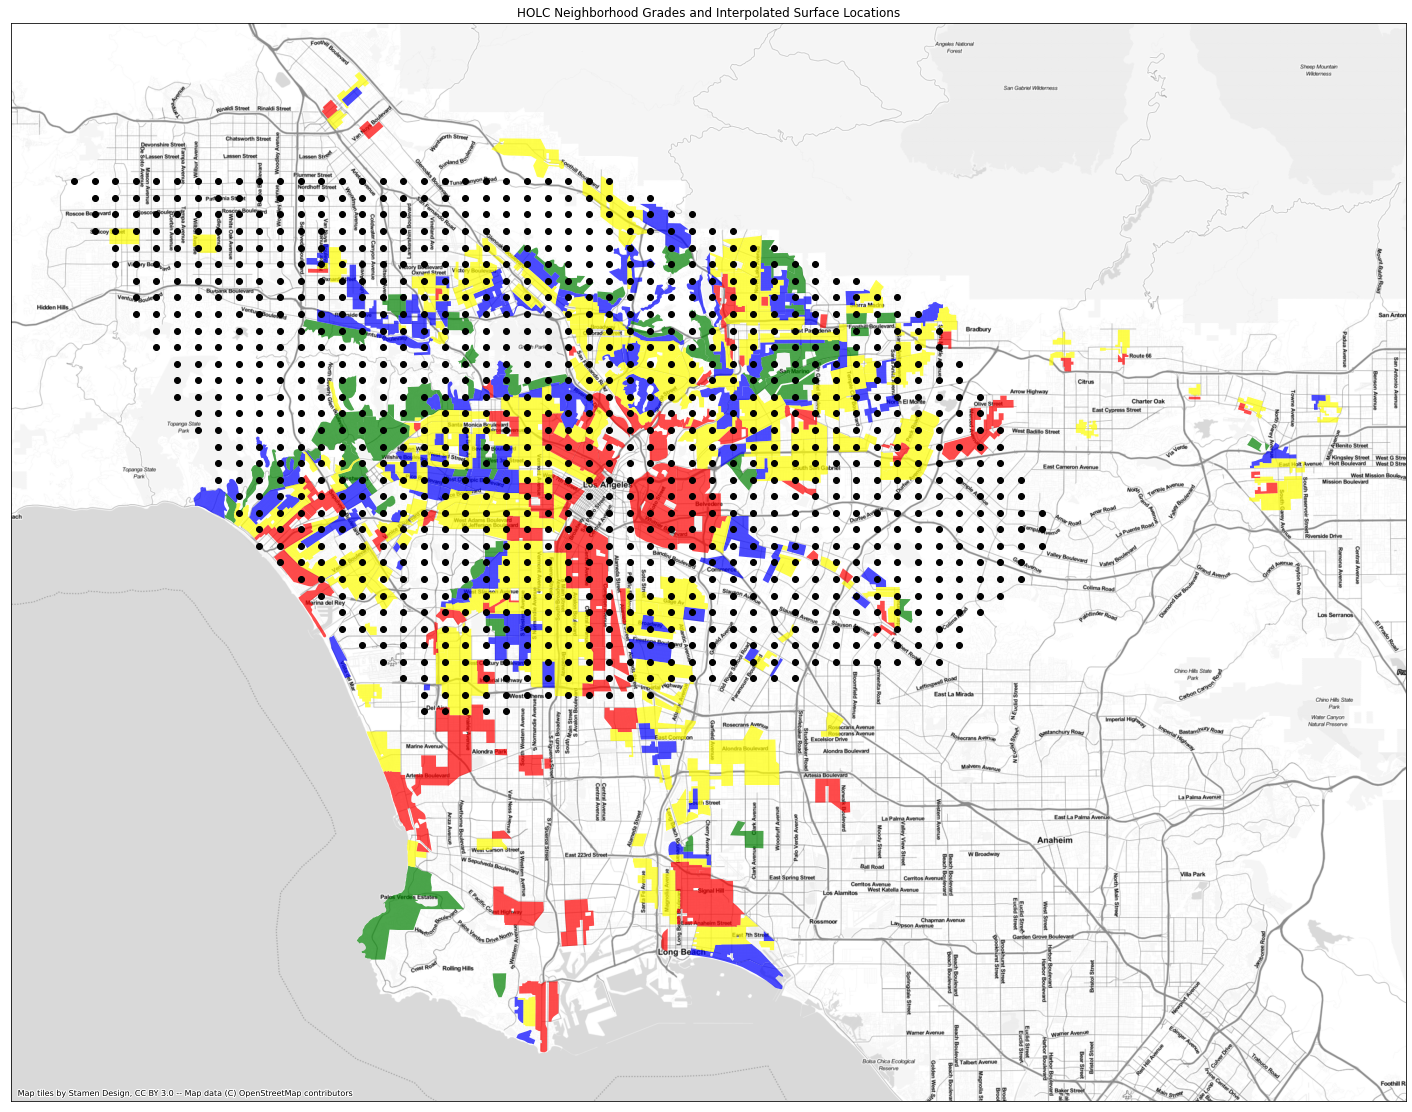

In [42]:
# Lastly, let's plot the data. We see that we instead of our sparsely populated sensors from the original plot we created,
# this plot has regularly spaced sensors throughout (most of) our study area.

fig, ax = plt.subplots(1,1, figsize=(25,25))
color_mapping = {"A": "green", "B": "blue", "C":"yellow","D":"red"}
holc.to_crs('EPSG:3857').plot(color=holc["holc_grade"].map(color_mapping),legend = True, ax=ax, alpha= 0.7)
aqgdf.to_crs('EPSG:3857').plot(ax=ax, color='black',alpha = 0.99)

ctx.add_basemap(ax, zoom = 12, source = ctx.providers.Stamen.TonerLite)

ax.set_xticks([])
ax.set_yticks([])

ax.set(title='HOLC Neighborhood Grades and Interpolated Surface Locations') 

## HOLC and Interpolated Surface Join Analysis

Now that we have created our interpolated surface, we can redo our spatial join and recreate our boxplot graph.

In [43]:
# Here we perform a left join, this time keeping all of our neighborhoods and creating duplicate rows where more than one 
# point from the interpolated surface lies in a neighborhood.

joindf = gpd.sjoin(holc.to_crs('EPSG:4326'), aqgdf.to_crs('EPSG:4326'), how="left", op='intersects')
joindf.holc_grade = joindf.holc_grade.fillna(value="NA")
joindf

name holc_id holc_grade  \
0    None      A1          A   
0    None      A1          A   
0    None      A1          A   
1    None     A10          A   
2    None     A11          A   
3    None     A12          A   
3    None     A12          A   
4    None     A13          A   
5    None     A14          A   
5    None     A14          A   
6    None     A15          A   
6    None     A15          A   
6    None     A15          A   
7    None     A16          A   
7    None     A16          A   
7    None     A16          A   
8    None     A17          A   
9    None     A18          A   
10   None     A19          A   
11   None      A2          A   
11   None      A2          A   
12   None     A20          A   
13   None     A21          A   
14   None     A22          A   
15   None     A23          A   
16   None     A24          A   
17   None     A25          A   
18   None     A26          A   
19   None     A27          A   
20   None     A28          A   
21   None     A29          A   
22   None      A3          A   
23   None     A30          A   
23   None     A30          A   
23   None     A30          A   
23   None     A30          A   
24   None     A31          A   
25   None     A32          A   
26   None     A33          A   
26   None     A33          A   
27   None     A34          A   
28   None     A35          A   
28   None     A35          A   
28   None     A35          A   
29   None     A36          A   
30   None     A37          A   
30   None     A37          A   
30   None     A37          A   
30   None     A37          A   
31   None     A38          A   
32   None     A39          A   
33   None      A4          A   
33   None      A4          A   
33   None      A4          A   
34   None     A40          A   
35   None     A41          A   
36   None     A42          A   
36   None     A42          A   
37   None     A43          A   
38   None     A46          A   
38   None     A46          A   
39   None     A47          A   
40   None     A48          A   
41   None     A49          A   
42   None      A5          A   
43   None     A50          A   
44   None     A51          A   
45   None     A52          A   
46   None     A53          A   
47   None     A54          A   
48   None     A55          A   
49   None     A56          A   
50   None     A58          A   
51   None     A59          A   
52   None      A6          A   
53   None     A60          A   
54   None      A7          A   
55   None      A8          A   
55   None      A8          A   
56   None      A9          A   
56   None      A9          A   
57   None      B1          B   
58   None     B10          B   
59   None    B100          B   
60   None    B101          B   
60   None    B101          B   
61   None    B102          B   
62   None    B103          B   
63   None    B104          B   
63   None    B104          B   
64   None    B105          B   
65   None    B106          B   
66   None    B107          B   
67   None    B108          B   
68   None    B109          B   
69   None     B11          B   
70   None    B110          B   
71   None    B111          B   
71   None    B111          B   
71   None    B111          B   
72   None    B112          B   
72   None    B112          B   
73   None    B113          B   
74   None    B114          B   
75   None    B115          B   
76   None    B116          B   
77   None    B117          B   
78   None    B118          B   
79   None    B119          B   
80   None     B12          B   
80   None     B12          B   
81   None    B120          B   
82   None    B121          B   
83   None    B122          B   
84   None     B13          B   
85   None     B14          B   
86   None     B15          B   
87   None     B16          B   
87   None     B16          B   
88   None     B17          B   
88   None     B17          B   
89   None     B18          B   
90   None     B19          B   
91   None      B2          B   
92   

In [44]:
# To create our boxplot, we want to analyze each neighborhood one time. So, we use a groupby to take the average sensor
# score for each neighborhood.

joindf = joindf.groupby(['holc_id']).mean('Avg PM 2.5').reset_index()
joindf['holc_grade'] = joindf['holc_id'].str[0]
joindf.head()

holc_id  index_right  Avg PM 2.5 holc_grade
0      A1       3764.0   12.595243          A
1     A10       5967.0   13.250590          A
2     A11       5965.0   14.205941          A
3     A12       5514.5   14.357330          A
4     A13       5463.0   14.845122          A

<AxesSubplot:title={'center':'Avg PM 2.5'}, xlabel='holc_grade'>

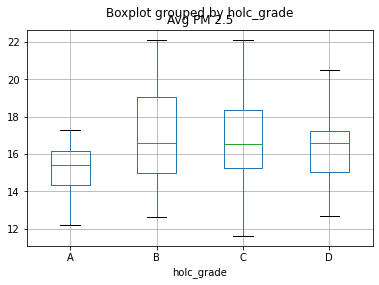

In [50]:
# And now we are ready to create the boxplot! We see that "A" neighborhoods have lower PM 2.5 scores than before. B, C, and 
# D neighborhoods, like before, have similar PM 2.5 scores.

joindf.boxplot('Avg PM 2.5', by = 'holc_grade', showfliers = False)

In [46]:
# This is a much more representative sample. We have at least 57 interpolated surface points for each neighborhood grade.

joindf.groupby('holc_grade').count()

holc_id  index_right  Avg PM 2.5
holc_grade                                  
A                57           33          33
B               121           63          63
C               167           98          98
D                71           28          28